# 泰坦尼克数据实践

In [13]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier, plot_importance 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
data = pd.read_csv("train.csv",)
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


    Survived:0代表死亡，1代表存活
    Pclass:乘客所持票类，有三种值(1,2,3)
    Name:乘客姓名(字符串)
    Sex:乘客性别(字符串)
    Age:乘客年龄(有缺失)
    SibSp:乘客兄弟姐妹/配偶的个数(整数值)
    Parch:乘客父母/孩子的个数(整数值)
    Ticket:票号(字符串)
    Fare:乘客所持票的价格(浮点数，0-500不等)
    Cabin:乘客所在船舱(有缺失)
    Embark:乘客登船港口:S、C、Q(有缺失)

In [14]:
data.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


## 简单的数据预处理

In [15]:
#性别处理
data['Sex'] = data['Sex'].map({'female': 0, 'male': 1}).astype(int)

In [16]:
#年龄处理
data["Age"] = data["Age"].fillna(data["Age"].median())

In [17]:
# 起始城市
data.loc[(data['Embarked'].isnull()), 'Embarked'] = 'S'
data = pd.get_dummies(data,prefix_sep='_', dummy_na=False, columns=['Embarked'])
data.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,0,0,1
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,0,0,1
5,6,0,3,"Moran, Mr. James",1,28.0,0,0,330877,8.4583,NaN,0,1,0
6,7,0,1,"McCarthy, Mr. Timothy J",1,54.0,0,0,17463,51.8625,E46,0,0,1
7,8,0,3,"Palsson, Master. Gosta Leonard",1,2.0,3,1,349909,21.0750,NaN,0,0,1
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",0,27.0,0,2,347742,11.1333,NaN,0,0,1
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",0,14.0,1,0,237736,30.0708,NaN,1,0,0


In [18]:
x = data[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked_C', 'Embarked_Q', 'Embarked_S']]
y = data['Survived']
x = np.array(x)
y = np.array(y)

In [8]:
# 思考：这样做是干什么的？
#x = np.tile(x, (5, 1))
#y = np.tile(y, (5, ))


## 常用模型准确率展示

In [8]:
dt=DecisionTreeClassifier()
lr=LogisticRegression(penalty='l2',solver='liblinear')
rf=RandomForestClassifier(n_estimators=100)
ada = AdaBoostClassifier()
xg = XGBClassifier()
svm = SVC(gamma="auto")

clf_list = [dt,lr, rf,ada,xg,svm]
label = [ 'DT','LR', 'RF', 'Ada', 'xgb', 'svm']

In [9]:
for clf, label in zip(clf_list, label):        
    scores = cross_val_score(clf, x, y, cv=10, scoring='accuracy')
    print(label,scores)
    print ("Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))

DT [0.76666667 0.8        0.73033708 0.78651685 0.80898876 0.7752809
 0.82022472 0.73033708 0.83146067 0.82954545]
Accuracy: 0.79 (+/- 0.04) [DT]
LR [0.77777778 0.78888889 0.7752809  0.84269663 0.78651685 0.7752809
 0.78651685 0.7752809  0.82022472 0.81818182]
Accuracy: 0.79 (+/- 0.02) [LR]
RF [0.72222222 0.81111111 0.76404494 0.85393258 0.87640449 0.84269663
 0.80898876 0.75280899 0.82022472 0.86363636]
Accuracy: 0.81 (+/- 0.05) [RF]
Ada [0.76666667 0.76666667 0.78651685 0.83146067 0.84269663 0.79775281
 0.80898876 0.85393258 0.83146067 0.82954545]
Accuracy: 0.81 (+/- 0.03) [Ada]
xgb [0.78888889 0.82222222 0.7752809  0.84269663 0.87640449 0.83146067
 0.83146067 0.7752809  0.84269663 0.84090909]
Accuracy: 0.82 (+/- 0.03) [xgb]
svm [0.64444444 0.6        0.70786517 0.73033708 0.73033708 0.73033708
 0.78651685 0.70786517 0.70786517 0.79545455]
Accuracy: 0.71 (+/- 0.06) [svm]


## 交叉验证调参方法

In [10]:
from sklearn.model_selection import  GridSearchCV
parameters_xg = {'max_depth':[3,6,7], 'learning_rate': [0.1,0.2], 'n_estimators': [300,200], 
                 'min_child_weight': [4], 'reg_alpha': [6,0], 'reg_lambda': [1,8],'max_delta_step':[2],
                 'gamma':[0],'seed':[1]}

parameters_svm = {'C':[0.9,0.01],'kernel':['rbf','linear'], 'gamma':[0,0.1,'auto'], 'probability':[True,False],
                  'random_state':[0,7,16],'decision_function_shape':['ovo','ovr'],'degree':[3,4,10]}

parameters_rf = {'n_estimators': [100,50], 'max_features': [7,'auto',None],
                 'n_jobs': [-1], 'min_samples_leaf': [2,4,], 'random_state':[1,7,], 
                 'min_samples_split':[2,6,], 'oob_score': [True,False],
                 'criterion': ['gini'], 'warm_start': [True,False]}


def grid(model,parameters):
    grid = GridSearchCV(estimator = model, param_grid = parameters, cv = 10, 
                        scoring = 'accuracy')
    grid.fit(x,y)
    return grid.best_score_, grid.best_estimator_.get_params()


In [11]:
%%time
best_score_svm, best_params_svm = grid(svm,parameters_svm)
print(best_score_svm)

C:\Users\zergt\.conda\envs\dl\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.7867564534231201
Wall time: 4h 49min 31s


In [12]:
%%time
best_score_xg, best_params_xg = grid(xg,parameters_xg)
print(best_score_xg)

0.8395061728395061
Wall time: 1min 14s


In [13]:
print (best_params_svm)

{'C': 0.9, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovo', 'degree': 3, 'gamma': 0, 'kernel': 'linear', 'max_iter': -1, 'probability': True, 'random_state': 0, 'shrinking': True, 'tol': 0.001, 'verbose': False}


In [14]:
print(best_params_xg)

{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 2, 'max_depth': 7, 'min_child_weight': 4, 'missing': None, 'n_estimators': 300, 'n_jobs': 1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 8, 'scale_pos_weight': 1, 'seed': 1, 'silent': None, 'subsample': 1, 'verbosity': 1}


## 数据深入处理

In [19]:
#对于Name的处理
import re

# 从title中获取名称
def get_title(name):
    # 使用正则表达式找到title中大写开头，并且.结束的，作为title
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

# 看看title是什么
titles = data["Name"].apply(get_title)
print(pd.value_counts(titles))

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Mlle          2
Major         2
Lady          1
Capt          1
Countess      1
Sir           1
Mme           1
Ms            1
Don           1
Jonkheer      1
Name: Name, dtype: int64


In [20]:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Dr": 5, "Rev": 6, "Major": 7, "Col": 7, "Mlle": 8, "Mme": 8, "Don": 9, "Lady": 10, "Countess": 10, "Jonkheer": 10, "Sir": 9, "Capt": 7, "Ms": 2}
for k,v in title_mapping.items():
    titles[titles == k] = v
print(pd.value_counts(titles))

1     517
2     183
3     125
4      40
5       7
6       6
7       5
10      3
8       3
9       2
Name: Name, dtype: int64


In [21]:
data["Title"] = titles

In [71]:
data.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked_C,Embarked_Q,Embarked_S,Title
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,0,0,1,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,1,0,0,3
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,0,1,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,0,0,1,3
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,0,0,1,1
5,6,0,3,"Moran, Mr. James",1,28.0,0,0,330877,8.4583,NaN,0,1,0,1
6,7,0,1,"McCarthy, Mr. Timothy J",1,54.0,0,0,17463,51.8625,E46,0,0,1,1
7,8,0,3,"Palsson, Master. Gosta Leonard",1,2.0,3,1,349909,21.0750,NaN,0,0,1,4
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",0,27.0,0,2,347742,11.1333,NaN,0,0,1,3
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",0,14.0,1,0,237736,30.0708,NaN,1,0,0,3


In [26]:
x = data[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked_C', 'Embarked_Q', 'Embarked_S','Title']]
y = data['Survived']
x = np.array(x)
y = np.array(y)

In [26]:
dt=DecisionTreeClassifier()
lr=LogisticRegression(penalty='l2',solver='liblinear')
rf=RandomForestClassifier(n_estimators=100)
ada = AdaBoostClassifier()
xg = XGBClassifier()
svm = SVC(gamma="auto")

clf_list = [dt,lr, rf,ada,xg,svm]
label = [ 'DT','LR', 'RF', 'Ada', 'xgb', 'svm']
for clf, label in zip(clf_list, label):        
    scores = cross_val_score(clf, x, y, cv=10, scoring='accuracy')
    print(label,scores)
    print ("Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))

DT [0.72222222 0.8        0.75280899 0.79775281 0.83146067 0.7752809
 0.82022472 0.70786517 0.78651685 0.85227273]
Accuracy: 0.78 (+/- 0.04) [DT]
LR [0.81111111 0.8        0.7752809  0.86516854 0.79775281 0.76404494
 0.80898876 0.78651685 0.82022472 0.81818182]
Accuracy: 0.80 (+/- 0.03) [LR]
RF [0.74444444 0.85555556 0.76404494 0.83146067 0.86516854 0.85393258
 0.78651685 0.75280899 0.82022472 0.85227273]
Accuracy: 0.81 (+/- 0.04) [RF]
Ada [0.77777778 0.8        0.78651685 0.84269663 0.84269663 0.79775281
 0.82022472 0.82022472 0.83146067 0.84090909]
Accuracy: 0.82 (+/- 0.02) [Ada]
xgb [0.81111111 0.78888889 0.7752809  0.86516854 0.8988764  0.83146067
 0.84269663 0.7752809  0.84269663 0.85227273]
Accuracy: 0.83 (+/- 0.04) [xgb]
svm [0.67777778 0.66666667 0.70786517 0.76404494 0.75280899 0.75280899
 0.79775281 0.74157303 0.78651685 0.78409091]
Accuracy: 0.74 (+/- 0.04) [svm]


## stacking （XGBOOST + LR 模型融合）

使用xgb训练特征，最后使用LR进行预测


In [149]:
dtrain = xgb.DMatrix(x, y,feature_names=['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked_C', 'Embarked_Q', 'Embarked_S','Title'])
#dtest = xgb.DMatrix(x, y)

In [150]:
params = {'booster': 'gbtree',
          'objective': 'binary:logistic',
          'subsample': 0.8,
          'colsample_bytree': 0.8,
          'eta': 0.1,
          'max_depth': 7,
          'min_child_weight': 1,
          'gamma': 0.0,
          'silent': 1,
          'seed': 0,
          'n_estimators': 300,
          'random_state': 0,
          'njob':1
          }
model = xgb.train(params, dtrain)

In [151]:
# predict() 返回每个样本分为 正类 1 的概率
model.predict(dtrain)[0]

0.23995237

In [152]:
# 设置 pred_leaf=True, 返回每个样本在每棵树上的叶子的 ID
y_pred_prob=model.predict(dtrain,pred_leaf=True)
y_pred_prob[0]

array([ 3,  4, 13, 12,  7, 12, 38, 65, 65, 17])

In [153]:
#使用onehot编码
from sklearn.preprocessing import OneHotEncoder
grd_enc = OneHotEncoder(categories='auto')
grd_enc.fit(y_pred_prob)
oh_train = grd_enc.transform(y_pred_prob).toarray()
oh_train[0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [154]:
oh_train.shape

(891, 272)

In [155]:
final_model = LogisticRegression( penalty='l2', solver='liblinear')
scores = cross_val_score(final_model, oh_train, y, cv=10, scoring='accuracy')

In [156]:
print(scores)
print(scores.mean())

[0.85555556 0.91111111 0.76404494 0.91011236 0.92134831 0.8988764
 0.88764045 0.82022472 0.8988764  0.88636364]
0.8754153898535921


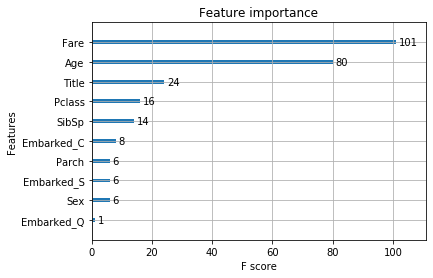

In [157]:
plot_importance(model)

## xgb调参方法

booster ：
    gbtree: tree-based models，树模型
    gblinear: linear models，线性模型

XGBoost有两种boosters,我们这里只看tree booster，原因是tree booster的表现总是好于 linear booster



```
eta [default=0.3] 
    与GBM中学习率的概念相似
    通过减小每一步的权重能够使得建立的模型更鲁棒
    通常最终的数值范围在[0.01-0.2]之间
    通过CV调参
    
min_child_weight [default=1] 
    定义观测样本生成的子节点的权重最小和
    这个概念与GBM中的min_child_leaf概念类似，但是又不完全一样，这个概念指的是某观测叶子节点中所有样本权重之和的最小值，而GBM指的是叶子节点的最少样本量
    用于防止过拟合问题：较大的值能防止过拟合，过大的值会导致欠拟合问题
    通过CV调参

max_depth [default=6] 
    树的最大深度
    用于防止过拟合问题
    通过CV调参
    通常值的范围：[3-10]

max_leaf_nodes 
    一棵树最多的叶子节点的数目
    与max_depth定义一个就好

gamma [default=0] 
    一个节点分裂的条件是其分裂能够起到降低loss function的作用，gamma 定义loss function降低多少才分裂
    这个变量使得算法变得保守，它的值取决于 loss function需要被调节
    通过CV调参

max_delta_step [default=0] 
    此变量的设置使得我们定义每棵树的权重估计值的变化幅度。如果值为0，值的变化没有限制，如果值>0，权重的变化将会变得相对保守
    通常这个参数不会被使用，但如果是极度不平衡的逻辑回归将会有所帮助

subsample [default=1]： 
    与GBM的subsample定义一样，指的是没有每棵树的样本比例
    低值使得模型更保守且能防止过拟合，但太低的值会导致欠拟合
    通常取值范围[0.5-1]
    通过CV调参

colsample_bytree [default=1] 
    与GBM中的max_features类似，指的是每棵树随机选取的特征的比例
    通常取值范围[0.5-1]
    通过CV调参

colsample_bylevel [default=1] 
    指的是树的每个层级分裂时子样本的特征所占的比例
    一般不用这个参数，因为subsample和colsample_bytree组合做的事与之类似

lambda [default=1] 
    l2正则化权重的术语（同 Ridge regression）
    用于处理XGBoost里的正则化部分，虽然很多数据科学家不怎么使用这个参数，但是它可以用于帮助防止过拟合

alpha [default=0] 
    l1正则化的权重术语（同Lasso regression）
    当特征量特别多的时候可以使用，这样能加快算法的运行效率

scale_pos_weight [default=1] 
    当样本不平衡时，需要设置一个大于0的数帮助算法尽快收敛
    
n_estimators 
    最佳迭代次数
    通过CV调参
```

任务参数：
objective 

    用于定义loss function，通常有以下几类
    binary:logistic-用于二分类，返回分类的概率而不是类别（class）
    multi:softmax-多分类问题，返回分类的类别而不是概率
    multi:softprob-与softmax类似，但是返回样本属于每一类的概率

eval_metric 

    这个变量用于 测试数据（validation data.）
    默认值：回归-rmse；分类-error
    rmse – root mean square error
    mae – mean absolute error
    logloss – negative log-likelihood
    error – Binary classification error rate (0.5 threshold)
    merror – Multiclass classification error rate
    mlogloss – Multiclass logloss
    auc: Area under the curve
    
有些变量在Python的sklearn的接口中对应命名如下： 

    1. eta -> learning rate 
    2. lambda ->reg_lambda 
    3. alpha -> reg_alpha
    
'tree_method': 'gpu_hist' / 'hist' GPU/CPU 

https://xgboost.readthedocs.io/en/latest/parameter.html

## 一元多项式回归

多项式回归就是把一次特征转换成高次特征的线性组合多项式


$
f(x)=w_{\{1\}}x + w_{\{2\}}x^2+w_{\{3\}}x^3+w_{\{4\}}x^4+...+w_{\{i\}}x^i+b
$

多元线性回归：

$
f(x)=w_{\{1\}}x_{\{1\}}+w_{\{2\}}x_{\{2\}}+w_{\{3\}}x_{\{3\}}+w_{\{4\}}x_{\{4\}}...+w_{\{i\}}x_{\{i\}}+b
$

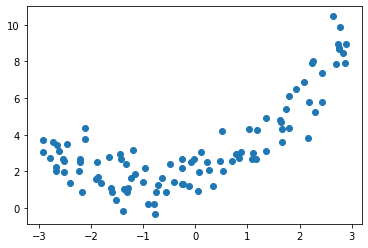

In [102]:
import numpy as np
import matplotlib.pyplot as plt
x = np.random.uniform(-3,3, size=100)
X = x.reshape(-1,1)
y = 0.5 * x**2 +x +2 + np.random.normal(0,1,size=100)
plt.scatter(x,y)
plt.show()

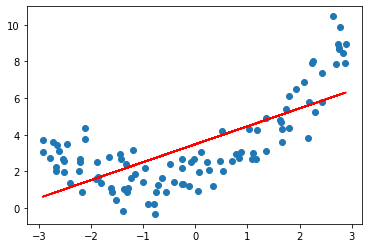

In [104]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X,y)
y_predict = lin_reg.predict(X)
plt.scatter(x,y)
plt.plot(x,y_predict,color='r')
plt.show()

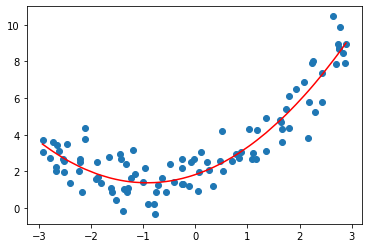

In [105]:
x2 = np.hstack([X,X**2]) #这里给样本X再引入1个特征项，现在的特征就有2个
lin_reg2 = LinearRegression()
lin_reg2.fit(x2,y)
y_predict2 = lin_reg2.predict(x2)
plt.scatter(x,y)
plt.plot(np.sort(x),y_predict2[np.argsort(x)],color='r') 
#绘制的时候要注意，因为x是无序的，为了画出如下图平滑的线条，需要先将x进行排序，y_predict2按照x从的大小的顺序进行取值，否则绘制出的如右下图

In [106]:
#检查拟合的系数，和原来预设的系数很接近
lin_reg2.coef_,lin_reg2.intercept_

(array([0.96947672, 0.52456555]), 1.8175336243864255)